In [2]:
## For Testing
from qiskit import QuantumCircuit, Aer, transpile, assemble
from qiskit.visualization import plot_histogram, plot_bloch_multivector
from numpy.random import randint
import numpy as np

In [16]:
qc = QuantumCircuit(2,2)

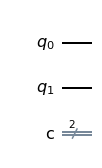

In [17]:
qc.draw(output='mpl')

In [18]:
qc.h(0)
qc.cx(0,1)
qc.measure([0,1],[0,1])

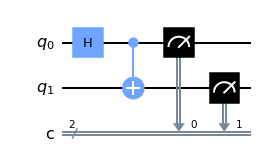

In [19]:
qc.draw(output='mpl')

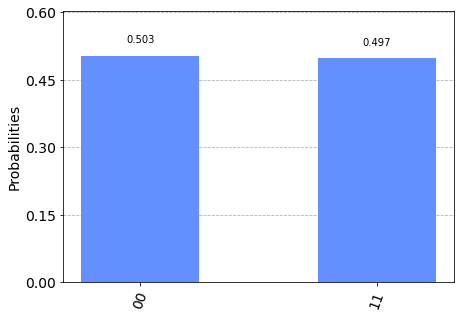

In [23]:
aer_sim = Aer.get_backend('aer_simulator')
job = aer_sim.run(assemble(qc))
plot_histogram(job.result().get_counts())